# Frequentism and Bayesianism V: Model Selection

*This notebook originally appeared as a [post](https://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/) on the blog [Pythonic Perambulations](http://jakevdp.github.io). The content is BSD licensed.*

*This post is part of a 5-part series: [Part I](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)  [Part II](http://jakevdp.github.io/blog/2014/06/06/frequentism-and-bayesianism-2-when-results-differ/)  [Part III](http://jakevdp.github.io/blog/2014/06/12/frequentism-and-bayesianism-3-confidence-credibility/)  [Part IV](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/) [Part V](http://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/)*

*See also [Frequentism and Bayesianism: A Python-driven Primer](http://arxiv.org/abs/1411.5018), a peer-reviewed article partially based on this content.*

<!-- PELICAN_BEGIN_SUMMARY -->

Last year I wrote a series of posts comparing frequentist and Bayesian approaches to various problems:

- In [Frequentism and Bayesianism I: a Practical Introduction](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/) I gave an introduction to the main philosophical differences between frequentism and Bayesianism, and showed that for many common problems the two methods give basically the same point estimates.
- In [Frequentism and Bayesianism II: When Results Differ](http://jakevdp.github.io/blog/2014/06/06/frequentism-and-bayesianism-2-when-results-differ/) I went into a bit more depth on when frequentism and Bayesianism start to diverge, particularly when it comes to the handling of nuisance parameters.
- In [Frequentism and Bayesianism III: Confidence, Credibility, and why Frequentism and Science Don't Mix](http://jakevdp.github.io/blog/2014/06/12/frequentism-and-bayesianism-3-confidence-credibility/) I talked about the subtle difference between frequentist confidence intervals and Bayesian credible intervals, and argued that in most scientific settings frequentism answers the wrong question.
- In [Frequentism and Bayesianism IV: How to be a Bayesian in Python](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/) I compared three Python packages for doing Bayesian analysis via MCMC: [emcee](http://dan.iel.fm/emcee), [pymc](http://pymc-devs.github.io/pymc/), and [pystan](https://pystan.readthedocs.org/en/latest/).

Here I am going to dive into an important topic that I've not yet covered: *model selection*.
We will take a look at this from both a frequentist and Bayesian standpoint, and along the way gain some more insight into the fundamental philosophical divide between frequentist and Bayesian methods, and the practical consequences of this divide.

My quick, TL;DR summary is this: for model selection, frequentist methods tend to be **conceptually difficult but computationally straightforward**, while Bayesian methods tend to be **conceptually straightforward but computationally difficult**.

<!-- PELICAN_END_SUMMARY -->

## Model Fitting vs Model Selection

The difference between *model fitting* and *model selection* is often a cause of confusion.
**Model fitting** proceeds by assuming a particular model is true, and tuning the model so it provides the best possible fit to the data. **Model selection**, on the other hand, asks the larger question of whether the assumptions of the model are compatible with the data.

Let's make this more concrete.
By *model* here I essentially mean a formula, usually with tunable parameters, which quantifies the likelihood of observing your data.
For example, your model might consist of the statement, "the $(x, y)$ observations come from a straight line, with known normal measurement errors $\sigma_y$".
Labeling this model $M_1$, we can write:

$$
y_{M_1}(x;\theta) = \theta_0 + \theta_1 x\\
y \sim \mathcal{N}(y_{M_1}, \sigma_y^2)
$$

where the second line indicates that the observed $y$ is normally distributed about the model value, with variance $\sigma_y^2$.
There are two tunable parameters to this model, represented by the vector $\theta = [\theta_0, \theta_1]$ (i.e. the slope and intercept).

Another model might consist of the statement "the observations $(x, y)$ come from a quadratic curve, with known normal measurement errors $\sigma_y$".
Labeling this model $M_2$, we can write:

$$
y_{M_2}(x;\theta) = \theta_0 + \theta_1 x + \theta_2 x^2\\
y \sim \mathcal{N}(y_{M_2}, \sigma_y^2)
$$

There are three tunable parameters here, again represented by the vector $\theta$.

Model fitting, in this case, is the process of finding constraints on the values of the parameters $\theta$ within each model.
That is, it allows you to make statements such as, "assuming $M_1$ is true, this particular $\theta$ gives the best-fit line" or "assuming $M_2$ is true, this particular vector $\theta$ gives the best-fit curve."
Model fitting proceeds without respect to whether the model is capable of describing the data well; it just arrives at the best-fit model *under the assumption that the model is accurate*.

Model selection, on the other hand, is not concerned with the parameters themselves, but with the question of whether the model is capable of describing the data well.
That is, it allows you to say, "for my data, a line ($M_1$) provides a better fit than a quadratic curve ($M_2$)".

Let's make this more concrete by introducing some data.

## Model Selection: Linear or Quadratic?

Consider the following data:

import numpy as np
'''data = np.array([[ 0.42,  0.72,  0.  ,  0.3 ,  0.15,
                   0.09,  0.19,  0.35,  0.4 ,  0.54,
                   0.42,  0.69,  0.2 ,  0.88,  0.03,
                   0.67,  0.42,  0.56,  0.14,  0.2  ],
                 [ 0.33,  0.41, -0.22,  0.01, -0.05,
                  -0.05, -0.12,  0.26,  0.29,  0.39, 
                   0.31,  0.42, -0.01,  0.58, -0.2 ,
                   0.52,  0.15,  0.32, -0.13, -0.09 ],
                 [ 0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1  ]])

x, y, sigma_y = data
'''

To get an idea of what we're looking at, let's quickly visualize these points:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='svg'
#%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.stats import LombScargle
plt.style.use('seaborn-whitegrid')

from scipy import integrate
import astropy
from astropy.time import Time

import pyfits
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.stats import LombScargle
import matplotlib.ticker as ticker

import numpy as np
from numpy import cov,corrcoef
import matplotlib.pyplot as plt
import astropy.units as u
from scipy.optimize import curve_fit
import scipy
import scipy.stats as stats
import pandas as pd
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression


from matplotlib import colors as mcolors

colors=dict(mcolors.BASE_COLORS,**mcolors.CSS4_COLORS)
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_color_names = [name for hsv, name in by_hsv]

marker=['.','v','^','<','>','1','2','3','4','8','s','p','P','*','h','H','+','x','X','D','d','|','_']
color=['red','sandybrown','tan','gold','olivedrab','chartreuse','darkgreen','blue','m','skyblue','violet','crimson','aqua','purple','magenta','yellow','lime','turquoise','lightcyan','teal','lightblue','indigo']
print(len(colors),len(marker),len(color))
marker3=marker+marker+marker
color3=color+color+color

print(len(marker3),len(color3))


156 23 22
69 66


In [2]:
def get_namelist(df,name):
    state=df[name]
    stateori=[]
    for i in state:
        if i not in stateori:
            stateori.append(i)
    return stateori

In [3]:
import pandas as pd
mutime=pd.read_excel('HM Cnc 08h06m22.9s +15d27m31s.xlsx')
mutime

date     Time(mjd)        P(s)   Mu(mHz)   Instrument         Paper  \
0   1994-1995  49648.900000  321.539300  3.110040        ROSAT    Hakala2003   
1     2001-02  52226.258000  321.533520  3.110096  VLT and NOT    Hakala2003   
2     2001-02  52281.416000  321.533140  3.110099      VLT+NOT    Hakala2004   
3        2003  52619.000000  321.530382  3.110126        Swift  Esposito2013   
4        2003  52645.443000  321.529570  3.110134          NOT    Hakala2003   
5        2003  52649.529000  321.530070  3.110129          NOT    Hakala2004   
6   2001-2004  53009.889944         NaN  3.110138      Chandra  Strohmayer05   
7        2004  53009.889944         NaN  3.110142      Chandra  Strohmayer05   
8   2003-2004  53030.395000  321.528320  3.110146      INT+NOT    Hakala2004   
9     2005-06  53802.804465  321.518906  3.110237      Chandra  Strohmayer08   
10    2004all  53009.882493  321.528000  3.110143    Chandrare       reduced   
11    2009all  55185.895669  321.524000  3.110182    Chandrare       reduced   
12       2004  53314.720952         NaN  3.110137        XMMre       reduced   
13       2017  58042.041465  321.492600  3.110492    NICER03re       reduced   
14       2017  58086.121079  321.510807  3.110315    NICER07re       reduced   

   Valid  
0    yes  
1    yes  
2    yes  
3    yes  
4    yes  
5    yes  
6    yes  
7    yes  
8    yes  
9     no  
10   yes  
11   yes  
12   yes  
13    no  
14   yes

11


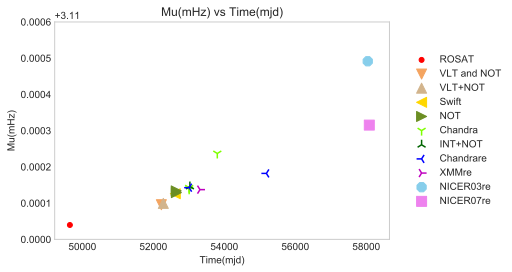

In [4]:
filename=mutime
parax='Time(mjd)'
paray='Mu(mHz)'
paralist='Instrument'
namelistall=get_namelist(filename,paralist)
print(len(namelistall))

namelist=namelistall[:]
#namelist=['V 404 Cyg']

plt.figure()
fit_x=np.logspace(30,38,base=10)
fit_y=pow(fit_x,0.61)*pow(10,29.65+0.15-0.61*36.32)

for i,m,c,in zip(namelist,marker[:len(namelist)],color[:len(namelist)]):
    x=filename[filename[paralist]==i][parax]
    y=filename[filename[paralist]==i][paray]
    plt.scatter(x,y,marker=m,color=c,label=i,s=100)#,s=(x+1)*20)
    plt.ylim(3.11,3.1106)
    #plt.xscale('log')
    #plt.yscale('log')
    
#plt.plot(fit_x,fit_y)
plt.xlabel(parax)
plt.ylabel(paray)
plt.title('%s vs %s'%(paray,parax))
plt.legend(loc='center', bbox_to_anchor=(1.2, 0.5),ncol=1)
plt.grid()
plt.savefig('MutimeofHMCNC_instrument.png')
plt.show()

In [128]:
filename=mutime
parax='Time(mjd)'
paray='Mu(mHz)'
paralist='Valid'
namelistall=get_namelist(filename,paralist)
namelist=['yes']
x=filename[filename[paralist]=='yes'][parax].values
y=filename[filename[paralist]=='yes'][paray].values
sigma_y=np.random.rand(len(x))*0.0000001

In [129]:
x,y,sigma_y

(array([ 49648.9       ,  52226.258     ,  52281.416     ,  52619.        ,
         52645.443     ,  52649.529     ,  53009.88994375,  53009.88994375,
         53030.395     ,  53009.8824927 ,  55185.8956688 ,  53314.7209522 ,
         58086.12107943]),
 array([ 3.1100397 ,  3.1100956 ,  3.1100993 ,  3.11012599,  3.1101338 ,
         3.110129  ,  3.11013824,  3.1101425 ,  3.1101459 ,  3.11014267,
         3.11018201,  3.11013726,  3.11031536]),
 array([  8.80736713e-08,   2.28801823e-08,   8.07806714e-08,
          5.25859305e-08,   5.63598297e-08,   5.63592027e-09,
          8.29589208e-08,   2.97271171e-08,   1.88964137e-08,
          2.74329105e-08,   4.41163320e-08,   1.11167154e-08,
          5.16209680e-08]))

data=np.array([[ 49648.9       ,  52226.258     ,  52281.416     ,  52619.        ,
         52645.443     ,  52649.529     ,  53009.88994375,  53009.88994375,
         53030.395     ,  53009.8824927 ,  55185.8956688 ,  53314.7209522 ,
         58086.12107943],[ 3.1100397 ,  3.1100956 ,  3.1100993 ,  3.11012599,  3.1101338 ,
         3.110129  ,  3.11013824,  3.1101425 ,  3.1101459 ,  3.11014267,
         3.11018201,  3.11013726,  3.11031536],[  5.48276452e-06,   8.47107857e-06,   6.30157582e-06,
          7.86939579e-06,   8.62380984e-06,   2.50078788e-06,
          5.48961270e-06,   2.92065180e-06,   3.17570877e-06,
          2.30136004e-06,   1.13726623e-06,   8.31217237e-06,
          9.13220347e-06]])

In [130]:
data=np.vstack([x, y, sigma_y])
x,y,sigma_y=data

In [131]:
data

array([[  4.96489000e+04,   5.22262580e+04,   5.22814160e+04,
          5.26190000e+04,   5.26454430e+04,   5.26495290e+04,
          5.30098899e+04,   5.30098899e+04,   5.30303950e+04,
          5.30098825e+04,   5.51858957e+04,   5.33147210e+04,
          5.80861211e+04],
       [  3.11003970e+00,   3.11009560e+00,   3.11009930e+00,
          3.11012599e+00,   3.11013380e+00,   3.11012900e+00,
          3.11013824e+00,   3.11014250e+00,   3.11014590e+00,
          3.11014267e+00,   3.11018201e+00,   3.11013726e+00,
          3.11031536e+00],
       [  8.80736713e-08,   2.28801823e-08,   8.07806714e-08,
          5.25859305e-08,   5.63598297e-08,   5.63592027e-09,
          8.29589208e-08,   2.97271171e-08,   1.88964137e-08,
          2.74329105e-08,   4.41163320e-08,   1.11167154e-08,
          5.16209680e-08]])

In [132]:
x,y,sigma_y

(array([ 49648.9       ,  52226.258     ,  52281.416     ,  52619.        ,
         52645.443     ,  52649.529     ,  53009.88994375,  53009.88994375,
         53030.395     ,  53009.8824927 ,  55185.8956688 ,  53314.7209522 ,
         58086.12107943]),
 array([ 3.1100397 ,  3.1100956 ,  3.1100993 ,  3.11012599,  3.1101338 ,
         3.110129  ,  3.11013824,  3.1101425 ,  3.1101459 ,  3.11014267,
         3.11018201,  3.11013726,  3.11031536]),
 array([  8.80736713e-08,   2.28801823e-08,   8.07806714e-08,
          5.25859305e-08,   5.63598297e-08,   5.63592027e-09,
          8.29589208e-08,   2.97271171e-08,   1.88964137e-08,
          2.74329105e-08,   4.41163320e-08,   1.11167154e-08,
          5.16209680e-08]))

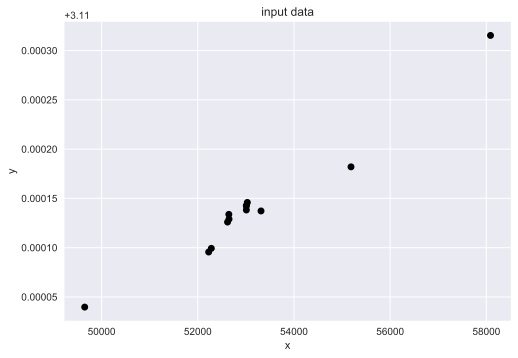

In [133]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # set default plot styles

fig, ax = plt.subplots()
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.set(xlabel='x', ylabel='y', title='input data');

Our central model selection question will be this: **what better fits this data: a linear ($M_1$) or quadratic ($M_2$) curve**?

Let's create a function to compute these models given some data and parameters; for convenience, we'll make a very general polynomial model function:

In [134]:
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * (x-x[0]) ** n for (n, t) in enumerate(theta))

If the ``theta`` variable is of length 2, this corresponds to the linear model ($M_1$). If the ``theta`` variable is length 3, this corresponds to the quadratic model ($M_2$).

As detailed in my previous posts, both the frequentist and Bayesian approaches to model fitting often revolve around the *likelihood*, which, for independent errors, is the product of the probabilities for each individual point.
Here is a function which computes the log-likelihood for the two models:

In [135]:
from scipy import stats

def logL(theta, model=polynomial_fit, data=data):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    if theta[1] <0:
        return -np.inf
    return sum(stats.norm.logpdf(*args) for args in zip(y, y_fit, sigma_y))

In [136]:
y[0],3.72*86400*10**-13,2.29e-22*86400*86400

(3.1100397000000002, 3.21408e-08, 1.70947584e-12)

In [137]:
len(x)

13

Both the Bayesian and frequentist approaches are based on the likelihood, and the standard frequentist approach is to find the model which maximizes this expression.
Though there are efficient closed-form ways of maximizing this, we'll use a direct optimization approach here for clarity:

In [144]:
from scipy import optimize

guess=np.array([y[0],3.1*10**-8,0.85*10**-12,1,1,1,1,1,1,1])

def best_theta(degree=1, model=polynomial_fit, data=data):
    theta_0 = guess[:degree+1]
    print(theta_0.round(5))
    #print()
    neg_logL = lambda theta: -logL(theta, model, data)
    return optimize.fmin_bfgs(neg_logL, theta_0, gtol=1e-13,disp=False)

theta1 = best_theta(1)
theta2 = best_theta(2)

[ 3.11004  0.     ]
[ 3.11004  0.       0.     ]


Let's now we can visually compare the maximum-likelihood degree-1 and degree-2 models:

In [145]:
theta1,theta2

(array([  3.11003970e+00,   3.10000000e-08]),
 array([  3.11003970e+00,   3.10000000e-08,   8.50000000e-13]))

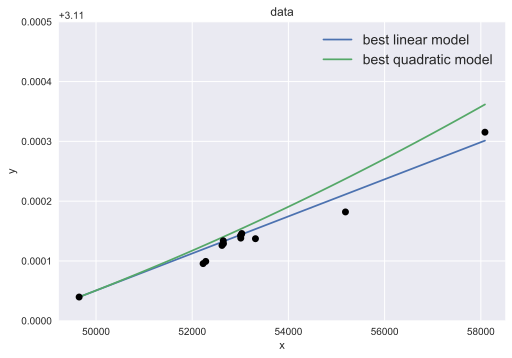

In [146]:
xfit = np.linspace(min(x), max(x), 100)
fig, ax = plt.subplots()
plt.ylim(3.11,3.1105)
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.plot(xfit, polynomial_fit(theta1, xfit), label='best linear model')
ax.plot(xfit, polynomial_fit(theta2, xfit), label='best quadratic model')
ax.legend(loc='best', fontsize=14)
ax.set(xlabel='x', ylabel='y', title='data');

The crux of the model selection question is this: how we can quantify the difference between these models and decide which model better describes our data?

### Naive Approach: Comparing Maximum Likelihoods

One common mistake is to assume that we can select between models via *the value of the maximum likelihood*.
While this works in some special cases, it is not generally applicable.
Let's take a look at the maximum log-likelihood value for each of our fits:

In [109]:
print("linear model:    logL =", logL(best_theta(1)))
print("quadratic model: logL =", logL(best_theta(2)))

[ 3.11  0.  ]
linear model:    logL = -909.573469067
[ 3.11  0.    0.  ]
quadratic model: logL = -981.249016004


The quadratic model yields a higher log-likelihood, but this **does not** necessarily mean it is the better model!

The problem is that the quadratic model has more degrees of freedom than the linear model, and thus will **always** give an equal or larger maximum likelihood, regardless of the data!
This trend holds generally: as you increase model complexity, the maximum likelihood value will (almost) always increase!

Let's take a look at the best maximum likelihood for a series of polynomial fits (linear, quadratic, cubic, quartic, etc.):

[ 3.11  0.  ]
[ 3.11  0.    0.  ]
[ 3.11  0.    0.    1.  ]


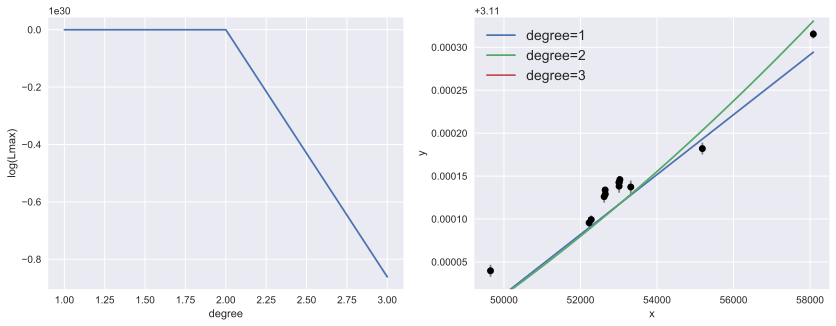

In [110]:
degrees = np.arange(1, 4)
thetas = [best_theta(d) for d in degrees]
logL_max = [logL(theta) for theta in thetas]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(degrees, logL_max)
ax[0].set(xlabel='degree', ylabel='log(Lmax)')
ax[1].errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ylim = ax[1].get_ylim()
for (degree, theta) in zip(degrees, thetas):
    if degree not in [1, 2,3]: continue
    ax[1].plot(xfit, polynomial_fit(theta, xfit),
               label='degree={0}'.format(degree))
ax[1].set(ylim=ylim, xlabel='x', ylabel='y')
ax[1].legend(fontsize=14, loc='best');

We see in the left panel that the maximum likelihood *value* always increases as we increase the degree of the polynomial.
Looking at the right panel, we see how this metric has led us astray: while the ninth order polynomial certainly leads to a larger likelihood, it achieves this by **over-fitting** the data.

Thus, in some ways, you can view the model selection question as fundamentally about comparing models while correcting for over-fitting of more complicated models.
Let's see how this is done within the frequentist and Bayesian approaches.

## Fundamentals of Frequentist & Bayesian Model Selection

Recall that the fundamental difference between the frequentist and Bayesian approaches is the [**definition of probability**](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/).

Frequentists consider **probabilities as frequencies**: that is, a probability is only meaningful in the context of repeated experiments (even if those repetitions are merely hypothetical).
This means, for example, that in the frequentist approach:

- *observed data* (and any quantities derived from them) are considered to be random variables: if you make the observations again under similar circumstances, the data may be different, and the details depend on the generating distribution.
- *model parameters* (those things that help define the generating distribution) are considered fixed: they aren't subject to a probability distribution; they just *are*.

On the other hand, Bayesians consider **probabilities as degrees-of-belief**: that is, a probability is a way of quantifying our certainty about a particular statement.
This means, for example, that in the Bayesian approach:

- *observed data* are not directly considered as random variables; they just *are*.
- *model parameters* are uncertain quantities and thus subject to probabilistic description.

This difference in philosophy has real, practical implications, as we will see below.

### Some Notation

Before we continue, a quick note on notation.
For the below discussion, it is important to be able to denote probabilities concisely.
We'll generally be writing conditional probabilities of the form $P(A~|~B)$, which can be read "the probability of A given B".
Additionally, I'll be using the following shorthands:

- $D$ represents observed data
- $M$, $M_1$, $M_2$, etc. represent a model
- $\theta$ represents a set of model parameters

With this in mind, we'll be writing statements like $P(D~|~\theta,M)$, which should be read "the probability of seeing the data, given the parameters $\theta$ with model $M$.
I'm playing a bit fast-and-loose with discrete vs continuous variables, but the meaning should be clear from the context.

### Model Fitting

In the model fitting context, the difference in philosopy of probability leads to frequentist and Bayesians dealing with different quantities:

- frequentists look at the *likelihood*: $P(D~|~\theta, M)$
- Bayesians look at the *posterior*: $P(\theta~|~D, M)$

Note the main distinction: frequentists operate on a **probability of the data**, while Bayesians operate on a **probability of the model parameters**, in line with their respective considerations about the applicability of probability.

**Frequentists**, here, have a clear advantage: the likelihood is something we can compute directly from the model – after all, a model is nothing more than a specification of the likelihood given model parameters.
By optimizing this likelihood expression directly, as we saw above, you can arrive at an estimated best-fit model.

**Bayesians**, on the other hand, have a slightly more difficult task.
To find an expression for the posterior, we can use Bayes' theroem:

$$
P(\theta~|~D,M) = P(D~|~\theta,M) \frac{P(\theta~|~M)}{P(D~|~M)}
$$

We see that the posterior is proportional to the likelihood used by frequentists, and the constant of proportionality involves ratio of $P(\theta~|~M)$ and $P(D~|~M)$.
$P(\theta~|~M)$ here is the *prior* and quantifies our belief/uncertainty about the parameters $\theta$ without reference to the data.
$P(D~|~M)$ is the *model evidence*, and in this context amounts to no more than a normalization term.

For a more detailed discussion of model fitting in the frequentist and Bayesian contexts, see the previous posts linked above.

### Model Selection

Similarly, when comparing two models $M_1$ and $M_2$, the frequentist and Bayesian approaches look at different quantities:

- frequentists compare the *model likelihood*, $P(D~|~M_1)$ and $P(D~|~M_2)$
- Bayesians compare the *model posterior*, $P(M_1~|~D)$ and $P(M_2~|~D)$

Notice here that the parameter values $\theta$ no longer appear: we're not out to compare how well *particular fits* of the two models describe data; we're out to compare how well *the models themselves* describe the data.
Unlike the parameter likelihood $P(D~|~\theta, M)$ above, neither quantity here is directly related to the likelihood expression, and so we must figure out how to re-express the desired quantity in terms we can compute.

#### Model Selection: Bayesian Approach

For model selection, in many ways Bayesians have the advantage, at least in theory.
Through a combination of Bayes Theorem and probability axioms, we can re-express the model posterior $P(M~|~D)$ in terms of computable quantities and priors:

First, using Bayes' Theorem:

$$
P(M~|~D) = P(D~|~M)\frac{P(M)}{P(D)}
$$

Using the definition of conditional probability, the first term can be expressed as an integral over the parameter space of the likelihood:

$$
P(D~|~M) = \int_\Omega P(D~|~\theta, M) P(\theta~|~M) d\theta
$$

Notice that this integral is over the exact quantity optimized in the case of Bayesian model *fitting*.

The remaining terms are priors, the most problematic of which is $P(D)$ – the prior probability of seeing your data *without reference to any model*.
I'm not sure that $P(D)$ could ever be actually computed in the real world, but fortunately it can be canceled by computing the *odds ratio* between two alternative models:

$$
O_{21} \equiv \frac{P(M_2~|~D)}{P(M_1~|~D)} = \frac{P(D~|~M_2)}{P(D~|~M_1)}\frac{P(M_2)}{P(M_1)}
$$

We now have a means of comparing two models via computable quantities: an integral over the likelihood, and a prior odds for each model.
Often the ratio of prior odds is assumed to be near unity, leaving only the well-defined (but often computationally intensive) integral over likelihood for each model.
More on this below.

#### Model Selection: Frequentist Approach

For model selection, frequentists are working with the quantity $P(D~|~M)$.
Notice that unlike Bayesians, frequentists *cannot* express this as an integral over parameter space, because the notion of a probability distribution over model parameters does not make sense in the frequentist context.
But recall that frequentists can make probabilistic statements about data or quantities derived from them: with this in mind, we can make progress by **computing some *statistic* from the data for which the distribution is known**.
The difficulty is that which statistic is most useful depends highly on the precise model and data being used, and so practicing frequentist statistics requires a breadth of background knowledge about the assumptions made by various approaches.

For example, one commonly-seen distribution for data-derived statistis is the [$\chi^2$ (chi-squared) distribution](https://en.wikipedia.org/wiki/Chi-squared_distribution).
The $\chi^2$ distribution with $K$ degrees of freedom describes the distribution of a sum of squares of $K$ independent normally-distributed variables.
We can use Python tools to quickly visualize this:

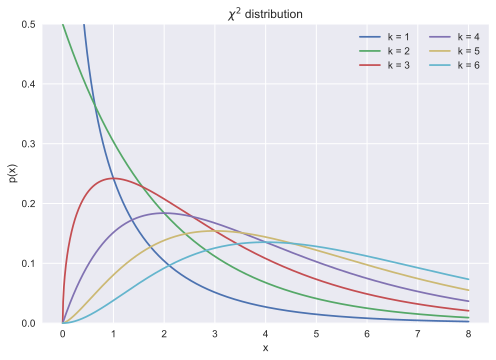

In [88]:
from scipy import stats
v = np.linspace(0, 8, 1000)
for k in range(1, 7):
    plt.plot(v, stats.chi2.pdf(v, k),
             label="k = {0}".format(k))
plt.legend(ncol=2)
plt.gca().set(title='$\chi^2$ distribution',
              xlabel='x', ylabel='p(x)', ylim=(0, 0.5));

The key observation is this: if we can somehow *transform our data* into a single statistic $S(D;\theta,M)$ which we expect behaves like the sum of squares of normally-distributed values, then we can analyze the likelihood of this statistic in terms of this $\chi^2$ distribution, and use this as a proxy for the model likelihood $P(D~|~M)$.

In the case of our linear and quadratic model likelihoods $M_1$ and $M_2$ above, the models are built on the explicit expectation that for the correct model, the observed data $y$ will be normally distributed about the model value $y_M$ with a standard deviation $\sigma_y$.
Thus the sum of squares of normalized residuals about the best-fit model should follow the $\chi^2$ distribution, and so we construct our $\chi^2$ statistic:

$$
\chi^2(D;\theta,M) = \sum_n\left[\frac{y_n - y_M(x_n;\theta)}{\sigma_{y,n}}\right]^2
$$

Coincidentally (or is it?), this statistic is proportional to the negative log likelihood, up to a constant offset, and so for model *fitting*, minimizing the $\chi^2$ is equivalent to maximizing the likelihood.

With this statistic, we've replaced an *uncomputable* quantity $P(D~|~M)$ with a *computable* quantity $P(S~|~M_S)$, where $S = \chi^2$ is a particular transformation of the data for which (under our model assumptions) we can compute the probability distribution.
So rather than asking "how likely are we to see the data $D$ under the model $M$", we can ask "how likely are we to see the statistic $S$ under the model $M_S$", and the two likelihoods will be equivalent *as long as our assumptions hold*.

## Frequentist and Bayesian Model Selection by Example

Let's use the ideas developed above to address the above model selection problem in both a frequentist and Bayesian context.

### Frequentist Model Selection: $\chi^2$

We introduced the $\chi^2$ statistic above, and now let's take a look at how this is actually computed.
From our proposed models, we explicitly expect that the residuals about the model fit will be independent and normally distributed, with variance $\sigma_y^2$.
Consequently, we expect that for the correct model, the sum of normalized residuals will be drawn from a $\chi^2$ distribuion with a degree of freedom related to the number of data points.
For $N$ data points fit by a $K$-parameter linear model, the degrees of freedom are usually given by $dof = N - K$, though there are some caveats to this (See [The Dos and Don'ts of Reduced Chi-Squared](http://arxiv.org/abs/1012.3754) for an enlightening discussion).

Let's define some functions to compute the $\chi^2$ and the number of degrees of freedom, and evaluate the likelihood of each model with the $\chi^2$ distribution:

In [89]:
def compute_chi2(degree, data=data):
    x, y, sigma_y = data
    theta = best_theta(degree, data=data)
    resid = (y - polynomial_fit(theta, x)) / sigma_y
    return np.sum(resid ** 2)

def compute_dof(degree, data=data):
    return data.shape[1] - (degree + 1)

def chi2_likelihood(degree, data=data):
    chi2 = compute_chi2(degree, data)
    dof = compute_dof(degree, data)
    return stats.chi2(dof).pdf(chi2)

print("chi2 likelihood")
print("- linear model:    ", chi2_likelihood(1))
print("- quadratic model: ", chi2_likelihood(2))

chi2 likelihood
[ 3.11  0.  ]
- linear model:     0.0
[ 3.11  0.    0.  ]
- quadratic model:  1.06473920126e-287


We have found that the likelihood of the observed residuals under the linear model ($M_1$) is slightly larger than the likelihood of the observed residuals under the quadratic model ($M_2$).

To understand what this is saying, it is helpful to visualize these distributions:

[ 3.11  0.  ]
[ 3.11  0.  ]
[ 3.11  0.    0.  ]
[ 3.11  0.    0.  ]


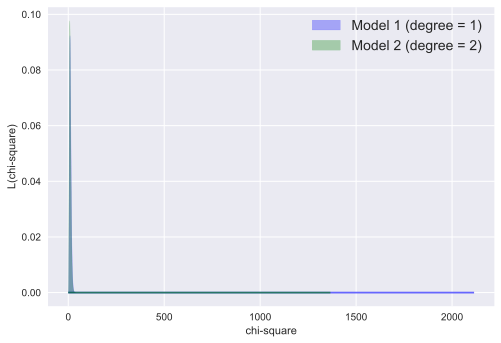

In [90]:
fig, ax = plt.subplots()
for degree, color in zip([1, 2], ['blue', 'green']):
    v = np.linspace(0, 40, 1000)
    chi2_dist = stats.chi2(compute_dof(degree)).pdf(v)
    chi2_val = compute_chi2(degree)
    chi2_like = chi2_likelihood(degree)
    ax.fill(v, chi2_dist, alpha=0.3, color=color,
            label='Model {0} (degree = {0})'.format(degree))
    ax.vlines(chi2_val, 0, chi2_like, color=color, alpha=0.6)
    ax.hlines(chi2_like, 0, chi2_val, color=color, alpha=0.6)
    ax.set(ylabel='L(chi-square)')
ax.set_xlabel('chi-square')
ax.legend(fontsize=14);

We can see visually here how this procedure corrects for model complexity: even though the $\chi^2$ *value* for the quadratic model is lower (shown by the vertical lines), the characteristics of the $\chi^2$ distribution mean the *likelihood* of seeing this value is lower (shown by the horizontal lines), meaning that the degree=1 linear model is favored.

#### Significance of the Comparison

But how much should we trust this conclusion in favor of the linear model?
In other words, how do we quantify the **significance** of this difference in $\chi^2$ likelihoods?

We can make progress by realizing that in the frequentist context *all data-derived quantities* can be consistered probabilistically, and this includes the difference in $\chi^2$ values from two models!
For this particular case, the difference of $\chi^2$ statistics here also follows a $\chi^2$ distribution, with 1 degree of freedom. This is due to the fact that the models are *nested* – that is, the linear model is a specialization of the quadratic model (for some background, look up the [Likelihood Ratio Test](https://en.wikipedia.org/wiki/Likelihood-ratio_test)).

We might proceed by treating the linear model as the *null hypothesis*, and asking if there is sufficient evidence to justify the more complicated quadratic model.
Just as above, we can plot the $\chi^2$ difference along with its expected distribution:

[ 3.11  0.  ]
[ 3.11  0.    0.  ]


/Users/brettlv/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in multiply


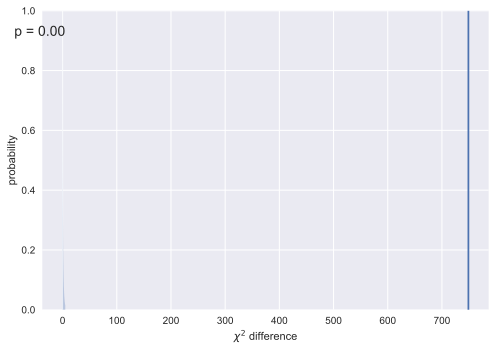

In [91]:
chi2_diff = compute_chi2(1) - compute_chi2(2)

v = np.linspace(0, 5, 1000)
chi2_dist = stats.chi2(1).pdf(v)
p_value = 1 - stats.chi2(1).cdf(chi2_diff)

fig, ax = plt.subplots()
ax.fill_between(v, 0, chi2_dist, alpha=0.3)
ax.fill_between(v, 0, chi2_dist * (v > chi2_diff), alpha=0.5)
ax.axvline(chi2_diff)
ax.set(ylim=(0, 1), xlabel="$\chi^2$ difference", ylabel="probability");
ax.text(4.9, 0.95, "p = {0:.2f}".format(p_value),
        ha='right', va='top', size=14);

Here we see where this observed $\chi^2$ difference lies on its expected distribution, under the null hypothesis that the linear model is the true model.
The area of the distribution to the right of the observed value is known as the [*p value*](https://en.wikipedia.org/wiki/P-value): for our data, the $p$-value is 0.17, meaning that, assuming the linear model is true, there is a 17% probability that simply by chance we would see data that favors the quadratic model more strongly than ours.
The standard interpretation of this is to say that our data are *not inconsistent with the linear model*: that is, our data does not support the quadratic model enough to conclusively reject the simpler linear model.

#### Other Frequentist Approaches

Recall that a primary purpose of using the $\chi^2$ statistic, above, was to prevent mistaken selection of very flexible models which *over-fit* the data.
Other qualitatively different approaches exist to limit this overfitting.
Some important ones are:

- [The Akaike Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) is an information-theoretic approach which penalizes the maximum likelihood to account for added model complexity. It makes rather stringent assumptions about the form of the likelihood, and so cannot be universally applied.
- [Cross-Validation](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29) is a sampling method in which the model fit and evaluation take place on disjoint randomized subsets of the data, which acts to penalize over-fitting. Cross-validation is more computationally intensive than other frequentist approaches, but has the advantage that it relies on very few assumptions about the data and model and so is applicable to a broad range of models.
- **Other sampling-based methods**: the classical frequentist approach relies on computing specially-crafted statistics that fit the assumptions of your model. Some of this specialization can be side-stepped through randomized methods like bootstrap and jackknife resampling.
For an interesting introduction to this subject, I'd recommend the short and free book, [Statistics is Easy](http://www.morganclaypool.com/doi/abs/10.2200/S00295ED1V01Y201009MAS008) by Shasha and Wilson, or the extremely approachable talk, [Statistics Without the Agonizing Pain](https://www.youtube.com/watch?v=5Dnw46eC-0o) by John Rauser.

We will not demonstrate these approaches here, but they are relatively straightforward and interesting to learn!

### Bayesian Model Selection: the Odds Ratio

The Bayesian approach proceeds very differently.
Recall that the Bayesian model involves computing the *odds ratio* between two models:

$$
O_{21} = \frac{P(M_2~|~D)}{P(M_1~|~D)} = \frac{P(D~|~M_2)}{P(D~|~M_1)}\frac{P(M_2)}{P(M_1)}
$$

Here the ratio $P(M_2) / P(M_1)$ is the *prior odds ratio*, and is often assumed to be equal to 1 if no compelling prior evidence favors one model over another.
The ratio $P(D~|~M_2) / P(D~|~M_1)$ is the *Bayes factor*, and is the key to Bayesian model selection.

The Bayes factor can be computed by evaluating the integral over the parameter likelihood:

$$
P(D~|~M) = \int_\Omega P(D~|~\theta, M) P(\theta~|~M) d\theta
$$

This integral is over the entire parameter space of the model, and thus can be extremely computationally intensive, especially as the dimension of the model grows beyond a few.
For the 2-dimensional and 3-dimensional models we are considering here, however, this integral can be computed directly via numerical integration.

We'll start, though, by using an MCMC to draw samples from the posterior in order to solve the *model fitting* problem.
We will use the [emcee](http://dan.iel.fm/emcee) package, which requires us to first define functions which compute the prior, likelihood, and posterior under each model:

In [92]:
def log_prior(theta):
    # size of theta determines the model.
    # flat prior over a large range
    if np.any(abs(theta) > 100):
        return -np.inf  # log(0)
    else:
        return 200 ** -len(theta)

def log_likelihood(theta, data=data):
    x, y, sigma_y = data
    yM = polynomial_fit(theta, x)
    return -0.5 * np.sum(np.log(2 * np.pi * sigma_y ** 2)
                         + (y - yM) ** 2 / sigma_y ** 2)

def log_posterior(theta, data=data):
    theta = np.asarray(theta)
    return log_prior(theta) + log_likelihood(theta, data)

Next we draw samples from the posterior using MCMC:

In [100]:
import emcee

def compute_mcmc(degree, data=data,
                   log_posterior=log_posterior,
                   nwalkers=50, nburn=1000, nsteps=2000):
    ndim = degree + 1  # this determines the model
    rng = np.random.RandomState(0)
    starting_guesses = rng.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])
    sampler.run_mcmc(starting_guesses, nsteps)
    trace = sampler.chain[:, nburn:, :].reshape(-1, ndim)
    return trace

trace_2D = compute_mcmc(1)
trace_3D = compute_mcmc(2)

The output is a trace, or a series of samples which by design should reflect the posterior distribution.
To visualize the posterior samples, I like to use seaborn's ``jointplot`` (for 2D samples) or ``PairGrid`` (for N-D samples):

In [101]:
import pandas as pd
columns = [r'$\theta_{0}$'.format(i) for i in range(3)]
df_2D = pd.DataFrame(trace_2D, columns=columns[:2])

with sns.axes_style('ticks'):
    jointplot = sns.jointplot(r'$\theta_0$', r'$\theta_1$',
                              data=df_2D, kind="hex");

In [118]:
t0,t1=map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(trace_2D, [16, 50, 84],
                                                axis=0)))

print(t0)
print(t1[0]/86400/1000)

(3.1100302879462332, 2.5794203448725739e-06, 2.5380631432092571e-06)
3.8142358906e-16


In [102]:
df_3D = pd.DataFrame(trace_3D, columns=columns[:3])

# get the colormap from the joint plot above
cmap = jointplot.ax_joint.collections[0].get_cmap()

with sns.axes_style('ticks'):
    grid = sns.PairGrid(df_3D)
    grid.map_diag(plt.hist, bins=30, alpha=0.5)
    grid.map_offdiag(plt.hexbin, gridsize=50, linewidths=0, cmap=cmap)

In [123]:
t0,t1,t2=map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(trace_3D, [16, 50, 84],
                                                axis=0)))

print(t0)
print(t1[0]/86400/1000)
print(t2[0]/86400/1000/86400)

(3.1100390056450467, 6.3569954953379693e-06, 6.3576723738911767e-06)
3.32643037216e-16
5.77120417239e-26


These samples give us a good idea of what the posterior for each model looks like, but we still must integrate this posterior to find the Bayes factor.

For these lower-dimensional models, we'll do direct numerical integration using tools from the ``scipy.integrate`` package to integrate the posterior and compute the odds ratio. 
The call signature of the multiple integration routines is a bit confusing – I suggest referring to the [scipy.integrate documentation](http://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html) to read about the inputs.

In [103]:
from scipy import integrate

def integrate_posterior_2D(log_posterior, xlim, ylim, data=data):
    func = lambda theta1, theta0: np.exp(log_posterior([theta0, theta1], data))
    return integrate.dblquad(func, xlim[0], xlim[1],
                             lambda x: ylim[0], lambda x: ylim[1])

def integrate_posterior_3D(log_posterior, xlim, ylim, zlim, data=data):
    func = lambda theta2, theta1, theta0: np.exp(log_posterior([theta0, theta1, theta2], data))
    return integrate.tplquad(func, xlim[0], xlim[1],
                             lambda x: ylim[0], lambda x: ylim[1],
                             lambda x, y: zlim[0], lambda x, y: zlim[1])

The tricky part of the integration is choosing the integration limits correctly; fortunately we can use the MCMC traces to find appropriate values.
We'll use IPython's ``%time`` magic to record how long each takes:

In [104]:
xlim, ylim = zip(trace_2D.min(0), trace_2D.max(0))
%time Z1, err_Z1 = integrate_posterior_2D(log_posterior, xlim, ylim)
print("Z1 =", Z1, "+/-", err_Z1)

CPU times: user 1.24 s, sys: 3.88 ms, total: 1.24 s
Wall time: 1.25 s
Z1 = 1.0072589919515592e+37 +/- 1.2441325028444457e+34


In [105]:
xlim, ylim, zlim = zip(trace_3D.min(0), trace_3D.max(0))
%time Z2, err_Z2 = integrate_posterior_3D(log_posterior, xlim, ylim, zlim)
print("Z2 =", Z2, "+/-", err_Z2)

CPU times: user 4min 21s, sys: 1.32 s, total: 4min 23s
Wall time: 4min 25s
Z2 = 2.269893339030117e+25 +/- 1.745391613529003e+31


The Bayes factor is simply the quotient of the two integrals:

In [111]:
print("Bayes factor:", Z2 / Z1)

Bayes factor: 2.2535349469873783e-12


The Bayes factor favors the quadratic model, but only slightly (an odds of about 7 to 3).
In fact, this value for the Bayes factor ranks as "not worth a mere mention" according to the scale proposed by [Kass & Raferty (1995)](https://www.andrew.cmu.edu/user/kk3n/simplicity/KassRaftery1995.pdf) an influential paper on the subject.

Notice that this interpretation is very similar to what we found with the frequentist approach above, which favors the quadratic model but has too large a $p$-value to support discarding the simpler linear model. Indeed, at the risk of causing die-hard Bayesians to cringe, you can argue roughly that the equivalent "Bayesian $p$-value" assosiated with this odds ratio is

In [112]:
print('Bayesian "p-value":', Z1 / (Z1 + Z2))

Bayesian "p-value": 0.9999999999977465


That is, the posterior probability in favor of the linear model is about 30%, which is not low enough to support rejecting the simpler model.
I put "$p$-value" here in quotes, because while a classical (frequentist) p-value reflects probability conditioned on the models, this Bayesian "$p$-value" reflects probability conditioned on the data, and so the detailed interpretation is very different.

#### Other Bayesian approaches

While direct numerical integration of the posterior works for low-dimensional models, computing Bayes factors for higher-dimensional models requires either a more sophisticated method, or an approximation of the integral.
For very high dimensional models, this is actually a very hard problem, and an area of active research.
Here is an incomplete list of approaches you might turn to in this case:

- [Nested Sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm) is a sampling-based algorithm like MCMC, which is specially designed to compute Bayes factors.
- [Reversible Jump MCMC](https://en.wikipedia.org/wiki/Reversible-jump_Markov_chain_Monte_Carlo) (also see *bridge sampling*) can be used to sample multiple models in the same MCMC chain, so that the Bayes factor can be estimated directly from the joint trace (see, e.g. [this paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.399.8889&rep=rep1&type=pdf))
- **Posterior Predictive Checks** are an interesting means of assessing the fitness of sampled posteriors without having to explicitly compute the integral, by empirically comparing the [Posterior Predictive Distribution](https://en.wikipedia.org/wiki/Posterior_predictive_distribution) to the data. For a technical but relatively approachable introduction, I'd suggest this [1996 paper by Gelman](http://www.cs.princeton.edu/courses/archive/fall09/cos597A/papers/GelmanMengStern1996.pdf).
- [the Bayesian Information Criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion) quickly approximates the Bayes factor using rather strong assumptions about the form of the posterior. It is very similar in form to the Akaike Information Criterion (AIC), mentioned above.

Again, I will not demonstrate any of these techniques here, but my hope is that this post has given you the background to understand them from other available references.

## A Note On the Example Data

In case you were curious, both the frequentist and Bayesian approaches landed on the correct answer, in the sense that our data actually was drawn from a straight line.
Here is the function I used to generate the data used in this post:

In [ ]:
import numpy as np

def generate_data(N=20, rseed=1):
    rng = np.random.RandomState(rseed)
    x = rng.rand(N)
    sigma_y = 0.1 * np.ones(N)
    
    # linear model with noise
    y = x - 0.2 + sigma_y * rng.randn(N)
    return np.vstack([x, y, sigma_y]).round(2)

data = generate_data()

If you *really* want to get a feel for how these methods work and respond to different inputs, you might wish to [download the notebook](http://jakevdp.github.io/downloads/notebooks/FreqBayes5.ipynb), and re-run the analysis with different functional forms or random seeds.
In particular, you might think about how the above plots might change if the data were actually drawn from a quadratic function.
Do the actual results match your intuition?

## Some Final Thoughts

My hope is that the above examples give you a flavor of the essential aspects of model selection within the frequentist and Bayesian paradigms.
To summarize, I want to offer a few observations:

**Model comparison is mainly an exercise in preventing over-fitting.**
Though the value of the maximum likelihood may seem, at first glance, to be a useful metric for comparing models, when the models differ in degrees of freedom this intuition is misleading.
The frequentist approach addresses this by devising and computing some statistic which implicitly or explicitly accounts for model complexity.
The Bayesian approach addresses this by integrating over the model parameter space, which in effect acts to automatically penalize overly-complex models.

Frequentist and Bayesian model selection approaches have complementary strengths and weaknesses:

**Frequentist model selection** generally relies on the selection of specifically-constructed statistics which apply to the particular data and models being used.
Because any particular statistic is only applicable in a narrow set of cases, an effective frequentist statistician must have a depth and breadth of knowledge about the properties of common statistical distributions, as well as a well-honed intuition about when to choose one statistic over another.
This breadth of required knowledge is, in my mind, one of the weaknesses of the frequentist approach.
In particular, it all but invites misuse: because so many people who deal with data on a daily basis do not have an advanced degree in classical statistics, it is common to see statistics like the $\chi^2$ applied without due consideration of the assumptions required by the statistic.
On the other hand, the frequentist approach does have the advantage that once the correct frequentist statistic is found, the results can often be computed very efficiently.

**Bayesian model selection** takes a much more uniform approach: regardless of the data or model being used, the same posterior odds ratio approach is applicable.
Thus, in some senses, the Bayesian approach is conceptually much easier than the frequentist approach, which is perhaps why it appeals to so many scientists.
The disadvantage, of course, is computational complexity: integrating the posterior, especially for very high-dimensional models, can be very computationally expensive, and this computational expense makes it tempting to take shortcuts which might bias the results.

I hope you found this discussion helpful, and thanks for reading!

*This post was written entirely in the IPython notebook.  You can [download](http://jakevdp.github.io/downloads/notebooks/FreqBayes5.ipynb) this notebook, or see a static view on [nbviewer](http://nbviewer.ipython.org/url/jakevdp.github.io/downloads/notebooks/FreqBayes5.ipynb).*